In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import talib as ta
import bt

import warnings
warnings.filterwarnings('ignore')

import copy as cp
%matplotlib inline

## <span style="color:purple"> Helper functions and class definitions</span>

In [3]:
class SelectWhere(bt.Algo):

    """
    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal: DataFrame containing the signal (boolean DataFrame)


    """
    def __init__(self, signal):
        self.signal = signal
        
    # - - - - - - - - - -

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index: 
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected  

        # return True because we want to keep on moving down the stack
        return True


In [5]:
DATA_PATH = ""

def read_data(file):
    df = pd.read_csv(file, parse_dates=True, index_col='Date')
    return df

price_data = read_data(DATA_PATH + 'Silver_CM_sorted.csv')
#price_data.set_index('Date', inplace = True)

In [6]:
price_data_train = price_data[price_data.index.astype(str)<'2022-01-01']
price_data_train2 = price_data_train[['Close']].copy()

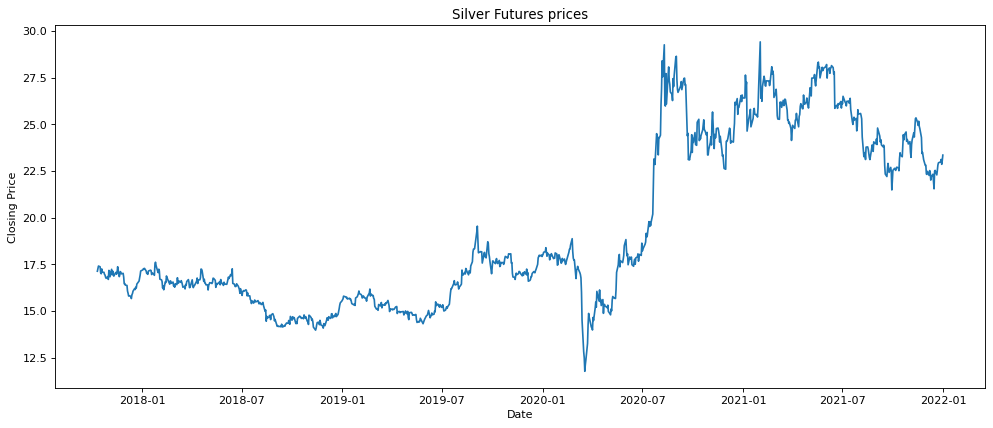

In [7]:
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(price_data_train2)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Silver Futures prices")
plt.show()

# <span style="color:purple"> Preprocessing </span> 

## Dependent variable (target feature)

In [8]:
price_data_train2['log_ret'] = np.log1p(price_data_train2["Close"].pct_change())

In [9]:
price_data_train2['positive_return_dummy'] = np.where(price_data_train2['log_ret'] > 0, 1, 0)

## Independent variables


### Historical Volatility 

In [10]:
price_data_train2['vol_5day'] = price_data_train2['log_ret'].rolling(window=5).std()*(365**0.5)
price_data_train2['vol_10day'] = price_data_train2['log_ret'].rolling(window=10).std()*(365**0.5)
price_data_train2['vol_20day'] = price_data_train2['log_ret'].rolling(window=20).std()*(365**0.5)
price_data_train2['vol_30day'] = price_data_train2['log_ret'].rolling(window=30).std()*(365**0.5)
price_data_train2['vol_60day'] = price_data_train2['log_ret'].rolling(window=60).std()*(365**0.5)
price_data_train2['vol_120day'] = price_data_train2['log_ret'].rolling(window=120).std()*(365**0.5)

### SMA (simple moving average):


In [11]:
price_data_train2['SMA_5day'] = ta.SMA(price_data_train2['Close'],5)
price_data_train2['SMA_10day'] = ta.SMA(price_data_train2['Close'],10)
price_data_train2['SMA_20day'] = ta.SMA(price_data_train2['Close'],20)
price_data_train2['SMA_30day'] = ta.SMA(price_data_train2['Close'],30)
price_data_train2['SMA_60day'] = ta.SMA(price_data_train2['Close'],60)
price_data_train2['SMA_120day'] = ta.SMA(price_data_train2['Close'],120)

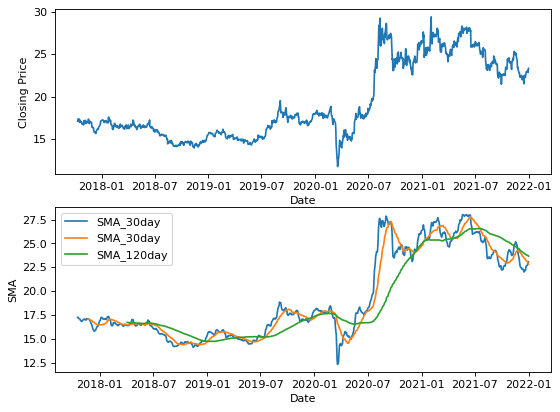

In [12]:
fig, ax = plt.subplots(2, figsize=(8, 6), dpi=80)
#fig.figsize(figsize=(8, 6), dpi=80)

ax[0].plot(price_data_train2['Close'])
ax[0].set(xlabel='Date', ylabel='Closing Price')


ax[1].plot(price_data_train2[['SMA_5day','SMA_30day','SMA_120day']])
ax[1].set(xlabel='Date', ylabel='SMA')
ax[1].legend(['SMA_30day', 'SMA_30day', 'SMA_120day'])

fig.show()

### EWMA (exponentially weighted moving average):  

In [13]:
price_data_train2['EMA_5day'] = ta.EMA(price_data_train2['Close'],5)
price_data_train2['EMA_10day'] = ta.EMA(price_data_train2['Close'],10)
price_data_train2['EMA_20day'] = ta.EMA(price_data_train2['Close'],20)
price_data_train2['EMA_30day'] = ta.EMA(price_data_train2['Close'],30)
price_data_train2['EMA_60day'] = ta.EMA(price_data_train2['Close'],60)
price_data_train2['EMA_120day'] = ta.EMA(price_data_train2['Close'],120)

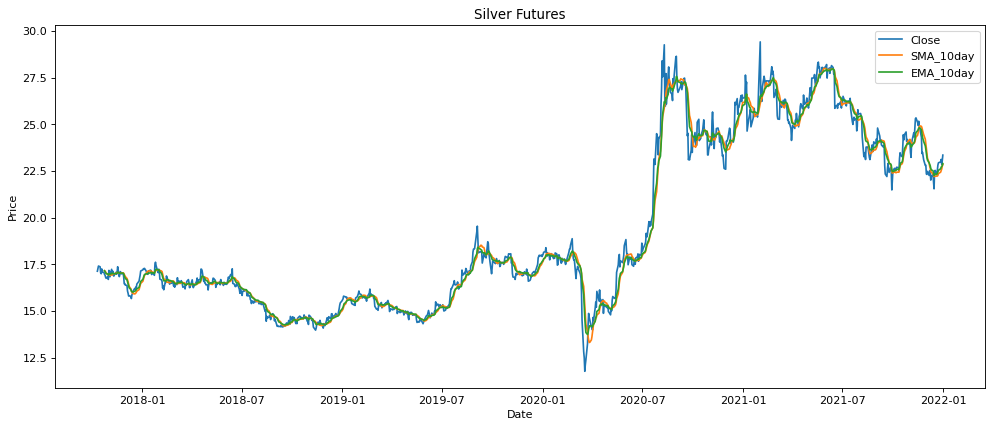

In [14]:
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(price_data_train2[['Close', 'SMA_10day', 'EMA_10day']])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Silver Futures")
plt.legend(['Close', 'SMA_10day', 'EMA_10day'])
plt.show()

### MACD (moving average convergence/divergence): 

In [15]:
price_data_train2['macd'], price_data_train2['macdsignal'], macdhist = ta.MACD(price_data_train2['Close'], fastperiod=12, slowperiod=26, signalperiod=9)


In [19]:
price_data_train2['MACD_Signal'] = np.where(price_data_train2['macd'] > price_data_train2['macdsignal'], 1, 0)
price_data_train2['MACD_Signal_shifted'] = price_data_train2['MACD_Signal'].shift(1)

In [20]:
conditions = [
    (price_data_train2['MACD_Signal'] > price_data_train2['MACD_Signal_shifted']),
    (price_data_train2['MACD_Signal'] < price_data_train2['MACD_Signal_shifted']),
    (price_data_train2['MACD_Signal'] == price_data_train2['MACD_Signal_shifted'])
    ]
values = ['green', 'red', '']
price_data_train2['MACD_Signal_color'] = np.select(conditions, values)

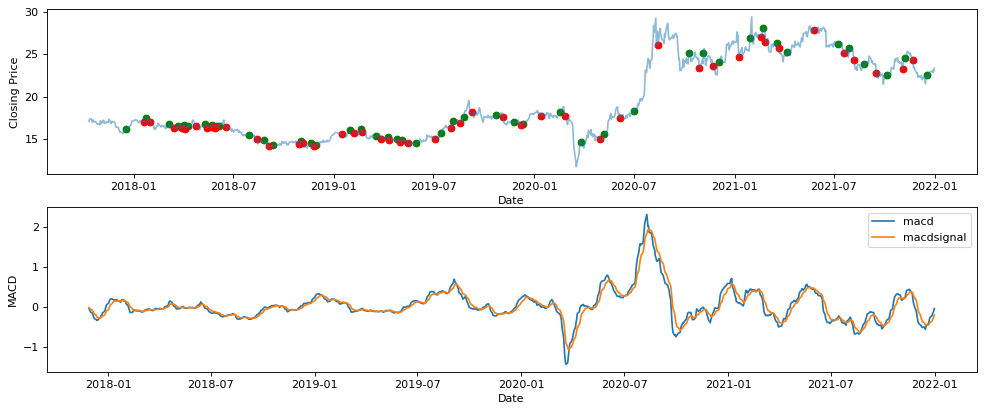

In [21]:
fig, ax = plt.subplots(2, figsize=(15, 6), dpi=80)
#fig.figsize(figsize=(8, 6), dpi=80)

ax[0].plot(price_data_train2['Close'], alpha = 0.5)
ax[0].scatter(price_data_train2[price_data_train2['MACD_Signal_color']=='green'].index, price_data_train2[price_data_train2['MACD_Signal_color']=='green']['Close'], c='green')
ax[0].scatter(price_data_train2[price_data_train2['MACD_Signal_color']=='red'].index, price_data_train2[price_data_train2['MACD_Signal_color']=='red']['Close'], c='red')
ax[0].set(xlabel='Date', ylabel='Closing Price')

ax[1].plot(price_data_train2[['macd','macdsignal']])
ax[1].set(xlabel='Date', ylabel='MACD')
ax[1].legend(['macd', 'macdsignal'])

fig.show()

### DX (directional movement index)

In [22]:
price_data_train2['DX_5day'] = ta.DX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],5)
price_data_train2['DX_10day'] = ta.DX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],10)
price_data_train2['DX_20day'] = ta.DX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],20)
price_data_train2['DX_30day'] = ta.DX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],30)
price_data_train2['DX_60day'] = ta.DX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],60)
price_data_train2['DX_120day'] = ta.DX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],120)

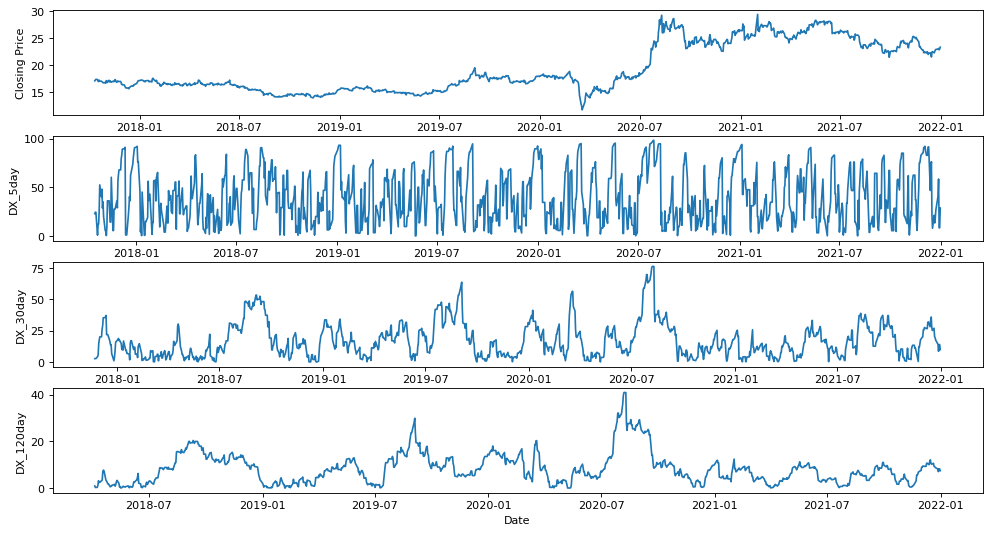

In [23]:
fig, ax = plt.subplots(4, figsize=(15, 8), dpi=80)
#fig.figsize(figsize=(8, 6), dpi=80)

ax[0].plot(price_data_train2['Close'])
ax[0].set(xlabel='Date', ylabel='Closing Price')

ax[1].plot(price_data_train2['DX_5day'])
ax[1].set(xlabel='Date', ylabel='DX_5day')

ax[2].plot(price_data_train2['DX_30day'])
ax[2].set(xlabel='Date', ylabel='DX_30day')

ax[3].plot(price_data_train2['DX_120day'])
ax[3].set(xlabel='Date', ylabel='DX_120day')

fig.show()

### ADX (average directional movement index)

In [24]:
price_data_train2['ADX_5day'] = ta.ADX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],5)
price_data_train2['ADX_10day'] = ta.ADX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],10)
price_data_train2['ADX_20day'] = ta.ADX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],20)
price_data_train2['ADX_30day'] = ta.ADX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],30)
price_data_train2['ADX_60day'] = ta.ADX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],60)
price_data_train2['ADX_120day'] = ta.ADX(price_data_train['High'], price_data_train['Low'], price_data_train2['Close'],120)

## Time structure

In [25]:
price_data_train2['positive_return_dummy'] = price_data_train2['positive_return_dummy'].shift(-1)

In [26]:
column_to_move = price_data_train2.pop('positive_return_dummy')
price_data_train2.insert(0, 'positive_return_dummy', column_to_move)
new_names = [(i,i+'_L01d') for i in price_data_train2.iloc[:,1:].columns.values]   
price_data_train2.rename(columns = dict(new_names), inplace=True)
price_data_train2.columns

Index(['positive_return_dummy', 'Close_L01d', 'log_ret_L01d', 'vol_5day_L01d',
       'vol_10day_L01d', 'vol_20day_L01d', 'vol_30day_L01d', 'vol_60day_L01d',
       'vol_120day_L01d', 'SMA_5day_L01d', 'SMA_10day_L01d', 'SMA_20day_L01d',
       'SMA_30day_L01d', 'SMA_60day_L01d', 'SMA_120day_L01d', 'EMA_5day_L01d',
       'EMA_10day_L01d', 'EMA_20day_L01d', 'EMA_30day_L01d', 'EMA_60day_L01d',
       'EMA_120day_L01d', 'macd_L01d', 'macdsignal_L01d', 'MACD_Signal_L01d',
       'MACD_Signal_shifted_L01d', 'MACD_Signal_color_L01d', 'DX_5day_L01d',
       'DX_10day_L01d', 'DX_20day_L01d', 'DX_30day_L01d', 'DX_60day_L01d',
       'DX_120day_L01d', 'ADX_5day_L01d', 'ADX_10day_L01d', 'ADX_20day_L01d',
       'ADX_30day_L01d', 'ADX_60day_L01d', 'ADX_120day_L01d'],
      dtype='object')

In [27]:
price_data_train2.pop('macd_L01d')
price_data_train2.pop('MACD_Signal_L01d')
price_data_train2.pop('MACD_Signal_shifted_L01d')
price_data_train2.pop('MACD_Signal_color_L01d')
price_data_train2.head()

,positive_return_dummy,Close_L01d,log_ret_L01d,vol_5day_L01d,vol_10day_L01d,vol_20day_L01d,vol_30day_L01d,vol_60day_L01d,vol_120day_L01d,SMA_5day_L01d,...,DX_20day_L01d,DX_30day_L01d,DX_60day_L01d,DX_120day_L01d,ADX_5day_L01d,ADX_10day_L01d,ADX_20day_L01d,ADX_30day_L01d,ADX_60day_L01d,ADX_120day_L01d
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-11,1.0,17.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-12,1.0,17.266,0.007733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-13,0.0,17.411,0.008363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-16,0.0,17.369,-0.002415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-17,0.0,17.041,-0.019065,NaN,NaN,NaN,NaN,NaN,NaN,17.244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <span style="color:purple"> Building some basic to toy models </span> 

## Take 1 linear model

In [28]:
all_columns = "+".join(price_data_train2.columns)
all_columns = all_columns.replace("positive_return_dummy+", "")
all_columns

'Close_L01d+log_ret_L01d+vol_5day_L01d+vol_10day_L01d+vol_20day_L01d+vol_30day_L01d+vol_60day_L01d+vol_120day_L01d+SMA_5day_L01d+SMA_10day_L01d+SMA_20day_L01d+SMA_30day_L01d+SMA_60day_L01d+SMA_120day_L01d+EMA_5day_L01d+EMA_10day_L01d+EMA_20day_L01d+EMA_30day_L01d+EMA_60day_L01d+EMA_120day_L01d+macdsignal_L01d+DX_5day_L01d+DX_10day_L01d+DX_20day_L01d+DX_30day_L01d+DX_60day_L01d+DX_120day_L01d+ADX_5day_L01d+ADX_10day_L01d+ADX_20day_L01d+ADX_30day_L01d+ADX_60day_L01d+ADX_120day_L01d'

In [29]:
my_formula = 'positive_return_dummy ~' + all_columns

model = smf.logit(my_formula, data = price_data_train2) 
logit_model_sm_take1 = model.fit()
print(logit_model_sm_take1.summary())

Optimization terminated successfully.
         Current function value: 0.658465
         Iterations 6
                             Logit Regression Results                            
Dep. Variable:     positive_return_dummy   No. Observations:                  824
Model:                             Logit   Df Residuals:                      790
Method:                              MLE   Df Model:                           33
Date:                   Tue, 03 Jan 2023   Pseudo R-squ.:                 0.04770
Time:                           06:32:39   Log-Likelihood:                -542.58
converged:                          True   LL-Null:                       -569.75
Covariance Type:               nonrobust   LLR p-value:                   0.01103
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2788      1.097      0.254      0.799      -1.872   

In [30]:
logit_model_sm_take1.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
         Logit Marginal Effects         
========================================
Dep. Variable:     positive_return_dummy
Method:                             dydx
At:                              overall
===================================================================================
                     dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Close_L01d         -0.2268      0.331     -0.686      0.493      -0.875       0.422
log_ret_L01d       -1.1520      2.643     -0.436      0.663      -6.332       4.028
vol_5day_L01d       0.3190      0.143      2.224      0.026       0.038       0.600
vol_10day_L01d     -0.7738      0.213     -3.637      0.000      -1.191      -0.357
vol_20day_L01d      0.2118      0.326      0.649      0.516      -0.427       0.851
vol_30day_L01d     -0.0532      0.374     -0.142      0.887      -0.786       0.679
vol_60day_L01d     -0.1810      0.411     -0.441      0.659      -0.986       0.624
vol_120day_L01d     1.1714      0.549      2.132      0.033       0.095       2.248
SMA_5day_L01d       0.3455      0.386      0.895      0.371      -0.411       1.102
SMA_10day_L01d      0.7980      0.423      1.888      0.059      -0.031       1.627
SMA_20day_L01d     -0.2155      0.396     -0.544      0.586      -0.992       0.561
SMA_30day_L01d      0.3554      0.405      0.878      0.380      -0.438       1.149
SMA_60day_L01d     -0.0183      0.291     -0.063      0.950      -0.588       0.552
SMA_120day_L01d     0.2789      0.199      1.405      0.160      -0.110       0.668
EMA_5day_L01d       3.9249      3.124      1.256      0.209      -2.199      10.049
EMA_10day_L01d     -6.8511      5.708     -1.200      0.230     -18.039       4.337
EMA_20day_L01d    -13.1855     18.630     -0.708      0.479     -49.700      23.329
EMA_30day_L01d     17.5331     19.842      0.884      0.377     -21.357      56.424
EMA_60day_L01d     -3.0233      3.332     -0.907      0.364      -9.555       3.508
EMA_120day_L01d     0.2720      0.460      0.591      0.555      -0.630       1.174
macdsignal_L01d     7.7710      7.253      1.071      0.284      -6.444      21.986
DX_5day_L01d        0.0023      0.002      1.353      0.176      -0.001       0.006
DX_10day_L01d      -0.0061      0.004     -1.501      0.133      -0.014       0.002
DX_20day_L01d      -0.0001      0.010     -0.011      0.991      -0.019       0.019
DX_30day_L01d       0.0153      0.012      1.225      0.221      -0.009       0.040
DX_60day_L01d      -0.0258      0.013     -1.947      0.052      -0.052       0.000
DX_120day_L01d      0.0212      0.011      1.889      0.059      -0.001       0.043
ADX_5day_L01d      -0.0017      0.003     -0.483      0.629      -0.008       0.005
ADX_10day_L01d      0.0089      0.008      1.141      0.254      -0.006       0.024
ADX_20day_L01d     -0.0044      0.023     -0.192      0.848      -0.049       0.040
ADX_30day_L01d     -0.0020      0.033     -0.062      0.950      -0.066       0.062
ADX_60day_L01d      0.0180      0.041      0.441      0.660      -0.062       0.098
ADX_120day_L01d    -0.0403      0.061     -0.656      0.512      -0.161       0.080
===================================================================================
"""

We can see that the coefficinets and the marginal effects of similar variables like SMA_05, SMA_10, SMA_20 are positive for some and negative for others. Since these variables are similar they should have a similar sign but because of high autocorreltaion ammong these variables, we see such a thing happening.

## Take 2 - Using variable selection

In [31]:
price_data_train2['vol_ratio_L01d'] = price_data_train2['vol_20day_L01d']/price_data_train2['vol_120day_L01d']
price_data_train2['SMA_ratio_L01d'] = price_data_train2['SMA_20day_L01d']/price_data_train2['SMA_120day_L01d']
price_data_train2['DX_ratio_L01d'] = price_data_train2['DX_20day_L01d']/price_data_train2['DX_120day_L01d']
price_data_train2['ADX_ratio_L01d'] = price_data_train2['ADX_20day_L01d']/price_data_train2['ADX_120day_L01d']

In [32]:
my_formula = 'positive_return_dummy ~ vol_ratio_L01d + SMA_ratio_L01d + DX_ratio_L01d + ADX_ratio_L01d + \
                vol_10day_L01d + SMA_10day_L01d + DX_10day_L01d + ADX_10day_L01d + macdsignal_L01d + Close_L01d'

model = smf.logit(my_formula, data = price_data_train2) 
logit_model_sm_take2 = model.fit()
print(logit_model_sm_take2.summary())

Optimization terminated successfully.
         Current function value: 0.682174
         Iterations 4
                             Logit Regression Results                            
Dep. Variable:     positive_return_dummy   No. Observations:                  824
Model:                             Logit   Df Residuals:                      813
Method:                              MLE   Df Model:                           10
Date:                   Tue, 03 Jan 2023   Pseudo R-squ.:                 0.01341
Time:                           06:32:51   Log-Likelihood:                -562.11
converged:                          True   LL-Null:                       -569.75
Covariance Type:               nonrobust   LLR p-value:                    0.1220
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5750      1.144      0.503      0.615      -1.668   

The R square value of take 2 is much worse than take 1, thus we can see that we have missed out on a few important variables when selecting them. 

## Take 3 - DecisionTree and Random Forest

In [37]:
price_data_train2.dropna(inplace = True)
y_train = price_data_train2[["positive_return_dummy"]]
X_train = price_data_train2.drop("positive_return_dummy", axis = 1)
dtc = DecisionTreeClassifier(max_depth=20).fit(X_train,y_train)
rfc = RandomForestClassifier(max_depth=20).fit(X_train,y_train)

# <span style="color:purple"> Validating the models </span> 

## Data prep

In [34]:
price_data_test = price_data[['Close']].copy()

price_data_test['log_ret'] = np.log1p(price_data_test["Close"].pct_change())

price_data_test['positive_return_dummy'] = np.where(price_data_test['log_ret'] > 0, 1, 0)

price_data_test['vol_5day'] = price_data_test['log_ret'].rolling(window=5).std()*(365**0.5)
price_data_test['vol_10day'] = price_data_test['log_ret'].rolling(window=10).std()*(365**0.5)
price_data_test['vol_20day'] = price_data_test['log_ret'].rolling(window=20).std()*(365**0.5)
price_data_test['vol_30day'] = price_data_test['log_ret'].rolling(window=30).std()*(365**0.5)
price_data_test['vol_60day'] = price_data_test['log_ret'].rolling(window=60).std()*(365**0.5)
price_data_test['vol_120day'] = price_data_test['log_ret'].rolling(window=120).std()*(365**0.5)

price_data_test['SMA_5day'] = ta.SMA(price_data_test['Close'],5)
price_data_test['SMA_10day'] = ta.SMA(price_data_test['Close'],10)
price_data_test['SMA_20day'] = ta.SMA(price_data_test['Close'],20)
price_data_test['SMA_30day'] = ta.SMA(price_data_test['Close'],30)
price_data_test['SMA_60day'] = ta.SMA(price_data_test['Close'],60)
price_data_test['SMA_120day'] = ta.SMA(price_data_test['Close'],120)

price_data_test['EMA_5day'] = ta.EMA(price_data_test['Close'],5)
price_data_test['EMA_10day'] = ta.EMA(price_data_test['Close'],10)
price_data_test['EMA_20day'] = ta.EMA(price_data_test['Close'],20)
price_data_test['EMA_30day'] = ta.EMA(price_data_test['Close'],30)
price_data_test['EMA_60day'] = ta.EMA(price_data_test['Close'],60)
price_data_test['EMA_120day'] = ta.EMA(price_data_test['Close'],120)

macd, price_data_test['macdsignal'], macdhist = ta.MACD(price_data_test['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

price_data_test['DX_5day'] = ta.DX(price_data['High'], price_data['Low'], price_data_test['Close'],5)
price_data_test['DX_10day'] = ta.DX(price_data['High'], price_data['Low'], price_data_test['Close'],10)
price_data_test['DX_20day'] = ta.DX(price_data['High'], price_data['Low'], price_data_test['Close'],20)
price_data_test['DX_30day'] = ta.DX(price_data['High'], price_data['Low'], price_data_test['Close'],30)
price_data_test['DX_60day'] = ta.DX(price_data['High'], price_data['Low'], price_data_test['Close'],60)
price_data_test['DX_120day'] = ta.DX(price_data['High'], price_data['Low'], price_data_test['Close'],120)

price_data_test['ADX_5day'] = ta.ADX(price_data['High'], price_data['Low'], price_data_test['Close'],5)
price_data_test['ADX_10day'] = ta.ADX(price_data['High'], price_data['Low'], price_data_test['Close'],10)
price_data_test['ADX_20day'] = ta.ADX(price_data['High'], price_data['Low'], price_data_test['Close'],20)
price_data_test['ADX_30day'] = ta.ADX(price_data['High'], price_data['Low'], price_data_test['Close'],30)
price_data_test['ADX_60day'] = ta.ADX(price_data['High'], price_data['Low'], price_data_test['Close'],60)
price_data_test['ADX_120day'] = ta.ADX(price_data['High'], price_data['Low'], price_data_test['Close'],120)

price_data_test['positive_return_dummy'] = price_data_test['positive_return_dummy'].shift(-1)

column_to_move = price_data_test.pop('positive_return_dummy')

price_data_test.insert(0, 'positive_return_dummy', column_to_move)
new_names = [(i,i+'_L01d') for i in price_data_test.iloc[:,1:].columns.values]   
price_data_test.rename(columns = dict(new_names), inplace=True)

price_data_test['vol_ratio_L01d'] = price_data_test['vol_20day_L01d']/price_data_test['vol_120day_L01d']
price_data_test['SMA_ratio_L01d'] = price_data_test['SMA_20day_L01d']/price_data_test['SMA_120day_L01d']
price_data_test['DX_ratio_L01d'] = price_data_test['DX_20day_L01d']/price_data_test['DX_120day_L01d']
price_data_test['ADX_ratio_L01d'] = price_data_test['ADX_20day_L01d']/price_data_test['ADX_120day_L01d']

price_data_test = price_data_test[~price_data.index.isin(price_data_train.index)]

price_data_test.head()


,positive_return_dummy,Close_L01d,log_ret_L01d,vol_5day_L01d,vol_10day_L01d,vol_20day_L01d,vol_30day_L01d,vol_60day_L01d,vol_120day_L01d,SMA_5day_L01d,...,ADX_5day_L01d,ADX_10day_L01d,ADX_20day_L01d,ADX_30day_L01d,ADX_60day_L01d,ADX_120day_L01d,vol_ratio_L01d,SMA_ratio_L01d,DX_ratio_L01d,ADX_ratio_L01d
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,1.0,22.810,-0.023484,0.292665,0.234977,0.295217,0.296266,0.288716,0.312026,23.0402,...,25.229329,24.181022,22.341190,18.152180,11.737747,6.495175,0.946129,0.953676,1.663136,3.439659
2022-01-04,1.0,23.056,0.010727,0.306810,0.226142,0.294220,0.299956,0.289866,0.312552,23.0272,...,23.003431,22.804587,21.966084,18.057871,11.772771,6.512798,0.941347,0.956478,1.723481,3.372757
2022-01-05,0.0,23.170,0.004932,0.284956,0.221310,0.291289,0.294314,0.290048,0.310355,23.0896,...,19.336866,20.712743,21.396383,17.873730,11.785632,6.525666,0.938567,0.958736,1.312159,3.278804
2022-01-06,1.0,22.190,-0.043217,0.470026,0.343674,0.347952,0.305616,0.308924,0.316133,22.9156,...,24.810136,21.645245,21.547930,18.001779,11.873240,6.556432,1.100653,0.959223,2.390716,3.286533
2022-01-07,1.0,22.409,0.009821,0.459631,0.349046,0.340443,0.307959,0.301388,0.316578,22.7270,...,29.647682,22.644327,21.736556,18.146176,11.964671,6.588240,1.075384,0.960942,2.440921,3.299296


In [38]:
X_test_take1 = price_data_test.drop(["positive_return_dummy", "vol_ratio_L01d", "SMA_ratio_L01d", "DX_ratio_L01d", \
                                "ADX_ratio_L01d"], axis = 1)
predict_test_logit_take1 = logit_model_sm_take1.predict(X_test_take1)

X_test_take2 = price_data_test[["vol_ratio_L01d", "SMA_ratio_L01d", "DX_ratio_L01d", "ADX_ratio_L01d", "vol_10day_L01d"\
                           , "SMA_10day_L01d", "DX_10day_L01d", "ADX_10day_L01d", "macdsignal_L01d", "Close_L01d"]]
predict_test_logit_take2 = logit_model_sm_take2.predict(X_test_take2)

X_test_take3 = price_data_test.drop("positive_return_dummy", axis = 1)
predict_test_dtc = dtc.predict_proba(X_test_take3)[:,1]

predict_test_rfc = rfc.predict_proba(X_test_take3)[:,1]


In [39]:
compare_test = pd.DataFrame({'actual': price_data_test['positive_return_dummy'], 'predict_test_logit_take1' : \
                        predict_test_logit_take1, 'predict_test_logit_take2' : predict_test_logit_take2, \
                        'predict_test_dtc' : predict_test_dtc, 'predict_test_rfc' : predict_test_rfc})
compare_test = compare_test.dropna()

print("Area under the ROC for Logit Take 1: ", round(roc_auc_score(compare_test['actual'], compare_test['predict_test_logit_take1']),3))
print("Area under the ROC for Logit Take 2: ", round(roc_auc_score(compare_test['actual'], compare_test['predict_test_logit_take2']),3))
print("Area under the ROC for Decision Tree: ", round(roc_auc_score(compare_test['actual'], compare_test['predict_test_dtc']),3))
print("Area under the ROC for Random Forest: ", round(roc_auc_score(compare_test['actual'], compare_test['predict_test_rfc']),3))


Area under the ROC for Logit Take 1:  0.549
Area under the ROC for Logit Take 2:  0.508
Area under the ROC for Decision Tree:  0.547
Area under the ROC for Random Forest:  0.578


According to the Area under the ROC, the Random Forest Classifier is the best model.

<span style="color:purple; font-size:30px">
    <b> Backtesting </b>
</span> 

# <span style="color:purple">  In-Sample Testing </span> 

## Data Prep

In [40]:
X_train_take1 = price_data_train2.drop(["positive_return_dummy", "vol_ratio_L01d", "SMA_ratio_L01d", "DX_ratio_L01d", \
                                "ADX_ratio_L01d"], axis = 1)
predict_train_logit_take1 = logit_model_sm_take1.predict(X_train_take1)

X_train_take2 = price_data_train2[["vol_ratio_L01d", "SMA_ratio_L01d", "DX_ratio_L01d", "ADX_ratio_L01d", "vol_10day_L01d"\
                           , "SMA_10day_L01d", "DX_10day_L01d", "ADX_10day_L01d", "macdsignal_L01d", "Close_L01d"]]
predict_train_logit_take2 = logit_model_sm_take2.predict(X_train_take2)

X_train_take3 = price_data_train2.drop("positive_return_dummy", axis = 1)
predict_train_dtc = dtc.predict_proba(X_train_take3)[:,1]

predict_train_rfc = rfc.predict_proba(X_train_take3)[:,1]


In [41]:
signals_train = pd.DataFrame(index=price_data_train2.index)
signals_train['predict_logit_take1'] = np.where(predict_train_logit_take1>0.5, True, False)
signals_train['predict_logit_take2'] = np.where(predict_train_logit_take2>0.5, True, False)
signals_train['predict_dtc'] = np.where(predict_train_dtc>0.5, True, False)
signals_train['predict_rfc'] = np.where(predict_train_rfc>0.5, True, False)
signals_train.head()

,predict_logit_take1,predict_logit_take2,predict_dtc,predict_rfc
Date,,,,
2018-09-24,True,True,True,True
2018-09-25,True,True,False,False
2018-09-26,True,True,False,False
2018-09-27,True,True,True,True
2018-09-28,True,False,False,False


In [42]:
price_train_for_bt = pd.DataFrame({'predict_logit_take1':price_data_train2['Close_L01d']})
price_train_for_bt['predict_logit_take2'] = price_data_train2['Close_L01d']
price_train_for_bt['predict_dtc'] = price_data_train2['Close_L01d']
price_train_for_bt['predict_rfc'] = price_data_train2['Close_L01d']
price_train_for_bt.head()

,predict_logit_take1,predict_logit_take2,predict_dtc,predict_rfc
Date,,,,
2018-09-24,14.341,14.341,14.341,14.341
2018-09-25,14.493,14.493,14.493,14.493
2018-09-26,14.401,14.401,14.401,14.401
2018-09-27,14.290,14.290,14.290,14.290
2018-09-28,14.712,14.712,14.712,14.712


## Individual Backtests
In this section, you will be performing backtesting using the bt package. <br>

`We can perform a backtesting following: ` 
```python 
algo_stack = [SelectWhere(signal), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy = bt.Strategy(strategy_name, algo_stack) 
bt_instance = bt.Backtest(strategy, closing_price)
res = bt.run(bt_instance)
``` 

`We can access the statistics of the backtest using `
```python 
res.stats 
``` 

`We can view the equity curve using `
```python 
res.plot() 
``` 
<br>
(Hint: To avoid unexpected bugs, the inputs into `SelectWhere()` and `bt.Backtest()` should be dataframes with the same column names)

<AxesSubplot:title={'center':'Equity Progression'}>

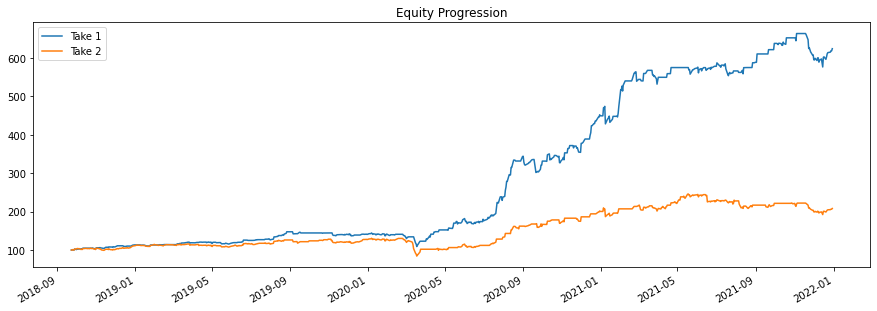

In [43]:
algo_stack_take1 = [SelectWhere(signals_train[['predict_logit_take1']]), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_take1 = bt.Strategy("Take 1", algo_stack_take1) 
bt_instance_take1 = bt.Backtest(strategy_take1, price_train_for_bt[['predict_logit_take1']])

algo_stack_take2 = [SelectWhere(signals_train[['predict_logit_take2']]), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_take2 = bt.Strategy("Take 2", algo_stack_take2) 
bt_instance_take2 = bt.Backtest(strategy_take2, price_train_for_bt[['predict_logit_take2']])

res = bt.run(bt_instance_take1, bt_instance_take2)
res.plot()

<AxesSubplot:title={'center':'Equity Progression'}>

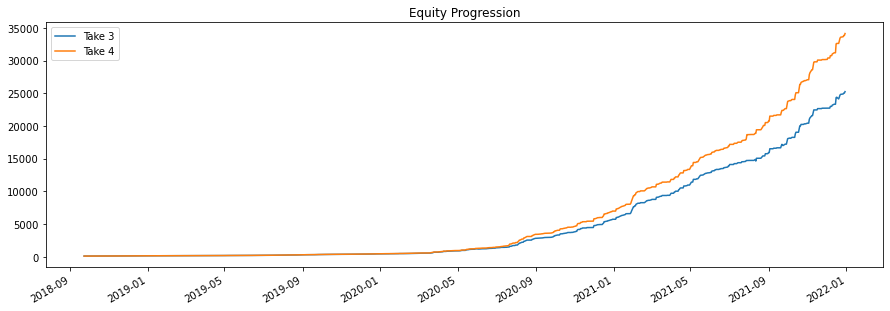

In [44]:
algo_stack_take3 = [SelectWhere(signals_train[['predict_dtc']]), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_take3 = bt.Strategy("Take 3", algo_stack_take3) 
bt_instance_take3 = bt.Backtest(strategy_take3, price_train_for_bt[['predict_dtc']])

algo_stack_take4 = [SelectWhere(signals_train[['predict_rfc']]), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_take4 = bt.Strategy("Take 4", algo_stack_take4) 
bt_instance_take4 = bt.Backtest(strategy_take4, price_train_for_bt[['predict_rfc']])

res = bt.run(bt_instance_take3, bt_instance_take4)
res.plot()

In [45]:
res = bt.run(bt_instance_take1, bt_instance_take2, bt_instance_take3, bt_instance_take4)
res.stats

,Take 1,Take 2,Take 3,Take 4
start,2018-09-23 00:00:00,2018-09-23 00:00:00,2018-09-23 00:00:00,2018-09-23 00:00:00
end,2021-12-30 00:00:00,2021-12-30 00:00:00,2021-12-30 00:00:00,2021-12-30 00:00:00
rf,0.0,0.0,0.0,0.0
total_return,5.242144,1.08164,251.505532,340.362483
cagr,0.751041,0.251416,4.430822,4.955554
max_drawdown,-0.260683,-0.354592,-0.030116,0.0
calmar,2.881047,0.70903,147.123803,inf
mtd,0.026515,0.022368,0.11095,0.131314
three_month,-0.021526,-0.060556,0.429077,0.468723
six_month,0.07924,-0.087763,0.81781,1.017149


We can see from the graphs that the CART models have done much better on in-sample data than the logit models. Especially the Random Forest has the best total return in-sample. Even the sharpe and sortino ratios are best for Random Forest which means it has given the biggest returns for the amount of risk taken.

# <span style="color:purple">  Out-of-Sample Testing </span> 

,Take 1,Take 2,Take 3,Take 4
start,2022-01-02 00:00:00,2022-01-02 00:00:00,2022-01-02 00:00:00,2022-01-02 00:00:00
end,2022-11-08 00:00:00,2022-11-08 00:00:00,2022-11-08 00:00:00,2022-11-08 00:00:00
rf,0.0,0.0,0.0,0.0
total_return,0.147328,0.165884,0.306285,0.101826
cagr,0.175778,0.198215,0.369995,0.121033
max_drawdown,-0.267303,-0.210849,-0.10557,-0.254156
calmar,0.657598,0.94008,3.504737,0.476217
mtd,0.121544,0.100346,0.121544,-0.00837
three_month,0.180563,0.215826,0.182653,0.031641
six_month,0.138459,0.19152,0.217557,-0.02018


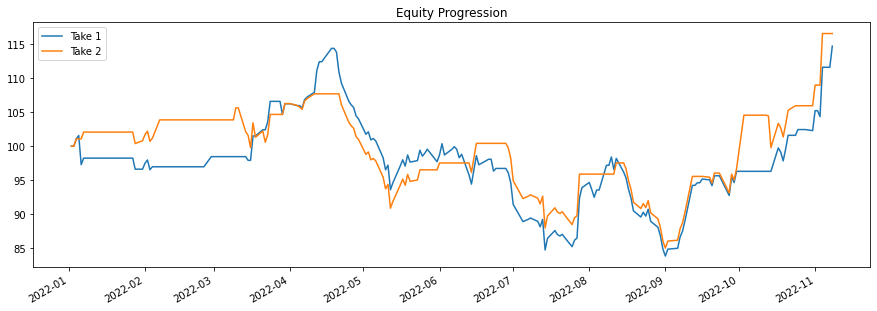

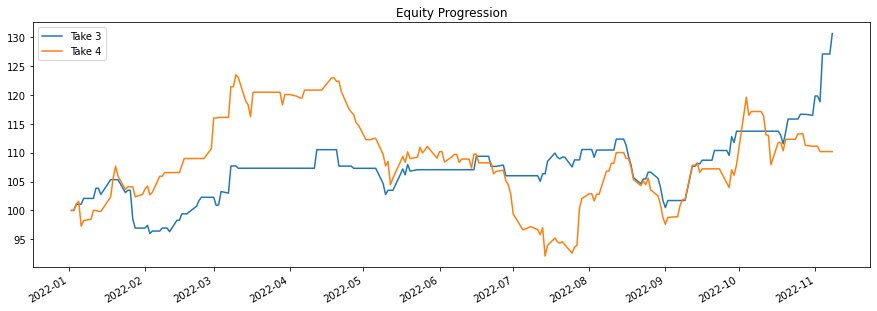

In [46]:
signals_test = pd.DataFrame(index=price_data_test.index)
signals_test['predict_logit_take1'] = np.where(predict_test_logit_take1>0.5, True, False)
signals_test['predict_logit_take2'] = np.where(predict_test_logit_take2>0.5, True, False)
signals_test['predict_dtc'] = np.where(predict_test_dtc>0.5, True, False)
signals_test['predict_rfc'] = np.where(predict_test_rfc>0.5, True, False)

price_test_for_bt = pd.DataFrame({'predict_logit_take1':price_data_test['Close_L01d']})
price_test_for_bt['predict_logit_take2'] = price_data_test['Close_L01d']
price_test_for_bt['predict_dtc'] = price_data_test['Close_L01d']
price_test_for_bt['predict_rfc'] = price_data_test['Close_L01d']

algo_stack_take1 = [SelectWhere(signals_test[['predict_logit_take1']]), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_take1 = bt.Strategy("Take 1", algo_stack_take1) 
bt_instance_take1 = bt.Backtest(strategy_take1, price_test_for_bt[['predict_logit_take1']])

algo_stack_take2 = [SelectWhere(signals_test[['predict_logit_take2']]), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_take2 = bt.Strategy("Take 2", algo_stack_take2) 
bt_instance_take2 = bt.Backtest(strategy_take2, price_test_for_bt[['predict_logit_take2']])

res1 = bt.run(bt_instance_take1, bt_instance_take2)
res1.plot()

algo_stack_take3 = [SelectWhere(signals_test[['predict_dtc']]), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_take3 = bt.Strategy("Take 3", algo_stack_take3) 
bt_instance_take3 = bt.Backtest(strategy_take3, price_test_for_bt[['predict_dtc']])

algo_stack_take4 = [SelectWhere(signals_test[['predict_rfc']]), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_take4 = bt.Strategy("Take 4", algo_stack_take4) 
bt_instance_take4 = bt.Backtest(strategy_take4, price_test_for_bt[['predict_rfc']])

res2 = bt.run(bt_instance_take3, bt_instance_take4)
res2.plot()

res3 = bt.run(bt_instance_take1, bt_instance_take2, bt_instance_take3, bt_instance_take4)
display(res3.stats)

From the out-of-sample returns, we can see that none of the 4 models have done great. The Random Forest still has the best returns but it is nowhere near what the results were for in-sample test. This shows that all 4 models were doing great in-sample but not so much for out-of-sample data.

Major challeneges-
The trading system works great in-sample but not out-of-sample.
It is difficult to segregate if a model is well trained or overfitted
The system is susceptible to marjet changes
Real time execution and execution in backtesting are very different and depend majorly on liquidity in the market
Explainability of model is difficult.

How to address these challenges-
Need to take extra care while training the model wherein the train data should consist of all different types of market regimes.
Analyse last few trades if trades have changed and change your model accordingly.
Implementing limit order execution in your backtesting.
Scenario analysis framework and backtest with different trading time sensitivities.